In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from py_experimenter.experimenter import PyExperimenter

# Get Data From DataBase

In [8]:
baseline_config_path = "dynabo/experiments/baseline_experiments/config.yml"
prior_config_path = "dynabo/experiments/dynabo_experiments/config.yml"
credentials_path = "config/database_credentials.yml"

In [9]:
baseline_experimenter = PyExperimenter(baseline_config_path, credentials_path)
prior_experimenter = PyExperimenter(prior_config_path, credentials_path)

2025-01-24 12:28:34,376  | py-experimenter - INFO     | Found 9 keyfields
2025-01-24 12:28:34,377  | py-experimenter - INFO     | Found 7 resultfields
2025-01-24 12:28:34,378  | py-experimenter - INFO     | Found 1 logtables
2025-01-24 12:28:34,379  | py-experimenter - INFO     | Found logtable baseline_lcbench__incumbents
2025-01-24 12:28:34,379  | py-experimenter - WARNING  | No custom section defined in config
2025-01-24 12:28:34,379  | py-experimenter - WARNING  | No codecarbon section defined in config
2025-01-24 12:28:34,489  | py-experimenter - INFO     | Initialized and connected to database
2025-01-24 12:28:34,501  | py-experimenter - INFO     | Found 13 keyfields
2025-01-24 12:28:34,502  | py-experimenter - INFO     | Found 7 resultfields
2025-01-24 12:28:34,503  | py-experimenter - INFO     | Found 2 logtables
2025-01-24 12:28:34,503  | py-experimenter - INFO     | Found logtable lcbench_prior_exp__incumbents
2025-01-24 12:28:34,503  | py-experimenter - INFO     | Found logt

In [10]:
baseline_table = baseline_experimenter.get_table()
baseline_incumbent_df = baseline_experimenter.get_logtable("incumbents")
baseline_incumbent_df = baseline_incumbent_df.drop(columns=["ID"])

prior_table = prior_experimenter.get_table()
prior_incumbent_df = prior_experimenter.get_logtable("incumbents")
prior_incumbent_df = prior_incumbent_df.drop(columns=["ID"])
prior_priors_df = prior_experimenter.get_logtable("priors")
prior_priors_df = prior_priors_df.drop(columns=["ID"])

In [11]:
joined_baseline_table = pd.merge(baseline_table, baseline_incumbent_df, left_on="ID", right_on="experiment_id")

joined_prior_incumbent_table = pd.merge(prior_table, prior_incumbent_df, left_on="ID", right_on="experiment_id")
joined_prio_prior_table = pd.merge(prior_table, prior_priors_df, left_on="ID", right_on="experiment_id")

In [12]:
joined_prior_incumbent_table.head()

,ID,benchmarklib,scenario,dataset,metric,prior_kind,prior_every_n_trials,validate_prior,prior_std_denominator,timeout_total,...,end_date,error,experiment_id,timestamp,performance,configuration,after_n_evaluations,after_runtime,after_virtual_runtime,after_reasoning_runtime
0,1,yahpogym,lcbench,3945,val_accuracy,good,50,0,5.0,86400,...,2025-01-22 15:07:50,None,1,2025-01-22 15:06:45,95.4177,"{'OpenML_task_id': '3945', 'batch_size': 40, '...",1,87.559,87.561,0.002
1,1,yahpogym,lcbench,3945,val_accuracy,good,50,0,5.0,86400,...,2025-01-22 15:07:50,None,1,2025-01-22 15:06:46,95.9242,"{'OpenML_task_id': '3945', 'batch_size': 120, ...",15,2304.380,2305.180,0.799
2,1,yahpogym,lcbench,3945,val_accuracy,good,50,0,5.0,86400,...,2025-01-22 15:07:50,None,1,2025-01-22 15:06:47,99.4358,"{'OpenML_task_id': '3945', 'batch_size': 18, '...",20,3035.150,3036.330,1.178
3,1,yahpogym,lcbench,3945,val_accuracy,good,50,0,5.0,86400,...,2025-01-22 15:07:50,None,1,2025-01-22 15:06:49,99.4999,"{'OpenML_task_id': '3945', 'batch_size': 16, '...",21,3122.180,3125.560,3.380
4,1,yahpogym,lcbench,3945,val_accuracy,good,50,0,5.0,86400,...,2025-01-22 15:07:50,None,1,2025-01-22 15:06:49,99.5033,"{'OpenML_task_id': '3945', 'batch_size': 16, '...",25,3465.170,3468.890,3.716


In [13]:
baseline_incumbent_df = joined_baseline_table[joined_baseline_table["dataset"] == "168331"]
prior_incumbent_df = joined_prior_incumbent_table[joined_prior_incumbent_table["dataset"] == "168331"]
prior_priors_df = joined_prio_prior_table[joined_prio_prior_table["dataset"] == "168331"]

In [14]:
baseline_incumbent_df.head()

,ID,benchmarklib,scenario,dataset,metric,timeout_total,timeout_internal,n_trials,initial_design_size,seed,...,end_date,error,experiment_id,timestamp,performance,configuration,after_n_evaluations,after_runtime,after_virtual_runtime,after_reasoning_runtime
440,21,yahpogym,lcbench,168331,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:12,None,21,2025-01-22 11:43:50,38.1729,"{'OpenML_task_id': '168331', 'batch_size': 40,...",1,90.981,90.984,0.003
441,21,yahpogym,lcbench,168331,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:12,None,21,2025-01-22 11:43:50,48.1558,"{'OpenML_task_id': '168331', 'batch_size': 21,...",4,582.188,582.375,0.187
442,21,yahpogym,lcbench,168331,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:12,None,21,2025-01-22 11:43:50,48.4388,"{'OpenML_task_id': '168331', 'batch_size': 53,...",17,2688.480,2688.790,0.314
443,21,yahpogym,lcbench,168331,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:12,None,21,2025-01-22 11:43:51,50.4809,"{'OpenML_task_id': '168331', 'batch_size': 20,...",21,3067.190,3068.170,0.982
444,21,yahpogym,lcbench,168331,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:12,None,21,2025-01-22 11:43:51,51.6040,"{'OpenML_task_id': '168331', 'batch_size': 39,...",25,3428.060,3429.190,1.123


In [15]:
joined_baseline_table.head()

,ID,benchmarklib,scenario,dataset,metric,timeout_total,timeout_internal,n_trials,initial_design_size,seed,...,end_date,error,experiment_id,timestamp,performance,configuration,after_n_evaluations,after_runtime,after_virtual_runtime,after_reasoning_runtime
0,1,yahpogym,lcbench,3945,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:09,None,1,2025-01-22 11:43:49,95.4177,"{'OpenML_task_id': '3945', 'batch_size': 40, '...",1,87.559,87.561,0.002
1,1,yahpogym,lcbench,3945,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:09,None,1,2025-01-22 11:43:49,95.9242,"{'OpenML_task_id': '3945', 'batch_size': 120, ...",15,2304.380,2304.490,0.110
2,1,yahpogym,lcbench,3945,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:09,None,1,2025-01-22 11:43:49,99.4358,"{'OpenML_task_id': '3945', 'batch_size': 18, '...",20,3035.150,3035.320,0.171
3,1,yahpogym,lcbench,3945,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:09,None,1,2025-01-22 11:43:49,99.4627,"{'OpenML_task_id': '3945', 'batch_size': 19, '...",21,3097.960,3098.780,0.824
4,1,yahpogym,lcbench,3945,val_accuracy,86400,1200,200,20,0,...,2025-01-22 11:44:09,None,1,2025-01-22 11:43:51,99.5033,"{'OpenML_task_id': '3945', 'batch_size': 18, '...",40,4900.870,4903.210,2.345


In [16]:
def find_last(df: pd.DataFrame, experiment_id: int, column: str, current: int):
    last_trial = df[(df["experiment_id"] == experiment_id) & (df[column] < current)]
    if len(last_trial) == 0:
        raise ValueError("No previous trial found")
    else:
        last_column_value = df[(df["experiment_id"] == experiment_id) & (df[column] < current)][column].max()
        df = df[(df["experiment_id"] == experiment_id) & (df[column] == last_column_value)]
        return df


def fill_df(iterator_df: pd.DataFrame, max_trials=200, x_axis_column: str = "after_n_evaluations"):
    rows = []
    for n_trials in sorted(iterator_df["after_n_evaluations"].unique()):
        if n_trials == 1:
            relevant_df = iterator_df[iterator_df["after_n_evaluations"] == n_trials]
            after_n_evaluations = n_trials
            after_runtime = relevant_df["after_runtime"].max()
            after_virtual_runtime = relevant_df["after_virtual_runtime"].max()
            after_reasoning_runtime = relevant_df["after_reasoning_runtime"].max()
            avg_performance = relevant_df["performance"].mean()
            std_performance = relevant_df["performance"].std()
            percentile_upper = np.percentile(relevant_df["performance"], 95)
            percentile_lower = np.percentile(relevant_df["performance"], 5)
            rows.append([after_n_evaluations, after_runtime, after_virtual_runtime, after_reasoning_runtime, avg_performance, std_performance, percentile_upper, percentile_lower])
        else:
            # Find row of last incumbent for each of the experiment_ids
            last_incumbent_rows = []
            for experiment_id in iterator_df["experiment_id"].unique():
                last = find_last(iterator_df, experiment_id, x_axis_column, n_trials)
                last_incumbent_rows.append(last)
            last_incumbent_df = pd.concat(last_incumbent_rows)
            after_n_evaluations = n_trials
            after_runtime = last_incumbent_df["after_runtime"].max()
            after_virtual_runtime = last_incumbent_df["after_virtual_runtime"].max()
            after_reasoning_runtime = last_incumbent_df["after_reasoning_runtime"].max()
            avg_performance = last_incumbent_df["performance"].mean()
            std_performance = last_incumbent_df["performance"].std()
            percentile_upper = np.percentile(last_incumbent_df["performance"], 95)
            percentile_lower = np.percentile(last_incumbent_df["performance"], 5)
            rows.append([after_n_evaluations, after_runtime, after_virtual_runtime, after_reasoning_runtime, avg_performance, std_performance, percentile_upper, percentile_lower])

    new_df = pd.DataFrame(
        rows, columns=["after_n_evaluations", "after_runtime", "after_virtual_runtime", "after_reasoning_runtime", "avg_performance", "std_performance", "percentile_upper", "percentile_lower"]
    )
    return new_df

In [17]:
def get_priors(priors_df: pd.DataFrame):
    prior_priors_df = pd.DataFrame(columns=["n_trials", "avg_performance", "percentile_upper", "percentile_lower"])
    priors = []
    for n_trials in sorted(priors_df["after_n_evaluations"].unique()):
        relevant_df = priors_df[priors_df["after_n_evaluations"] == n_trials]
        avg_performance = relevant_df["performance"].mean()
        percentile_upper = np.percentile(relevant_df["performance"], 95)
        percentile_lower = np.percentile(relevant_df["performance"], 5)
        priors.append([n_trials, avg_performance, percentile_upper, percentile_lower])
    prior_priors_df = pd.DataFrame(priors, columns=["n_trials", "avg_performance", "percentile_upper", "percentile_lower"])
    return prior_priors_df

In [18]:
new_df_baseline = fill_df(baseline_incumbent_df)
new_df_prior = fill_df(prior_incumbent_df)
# prior_priors_df = get_priors(prior_priors_df)

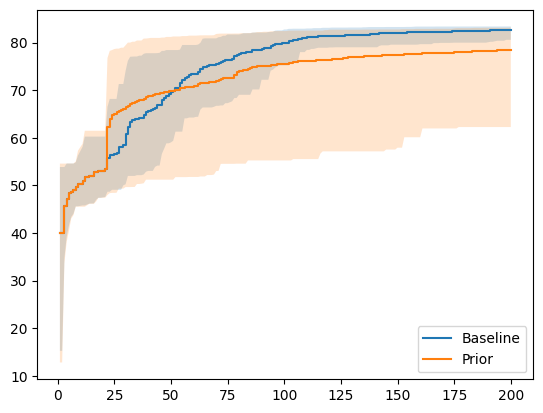

In [19]:
plt.step(new_df_baseline["after_n_evaluations"], new_df_baseline["avg_performance"], where="post", label="Baseline")
plt.fill_between(new_df_baseline["after_n_evaluations"], new_df_baseline["percentile_lower"], new_df_baseline["percentile_upper"], alpha=0.2)
plt.step(new_df_prior["after_n_evaluations"], new_df_prior["avg_performance"], where="post", label="Prior")
plt.fill_between(new_df_prior["after_n_evaluations"], new_df_prior["percentile_lower"], new_df_prior["percentile_upper"], alpha=0.2)
# plt.scatter(prior_priors_df["n_trials"], prior_priors_df["avg_performance"], label="Priors", color="red")
# plt.fill_between(prior_priors_df["n_trials"], prior_priors_df["percentile_lower"], prior_priors_df["percentile_upper"], alpha=0.2, color="red")
plt.legend()